### Import library and model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU
import tensorflow as tf
import random

### Import, scale and split Dataset

In [2]:
# Import Dataset
 # EUR - VND
eur = pd.read_csv('..\Dataset\EUR.csv')
 # GBP - VND
gbp = pd.read_csv("..\Dataset\GBP.csv")
 # JPY - VND
jpy = pd.read_csv("..\Dataset\JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

### MinMaxScaler

In [3]:
# Scaler model
scaler=MinMaxScaler(feature_range=(0,1))

### Standardizate function

In [4]:
# Function to standardizate the data
def standardizate_data(train, test, pre_test, f3, f6, f9):
    # Train
    train = np.reshape(train, (-1,1))
    train1 = scaler.inverse_transform(train)
    # Test
    test = np.reshape(test, (-1,1))
    test1 = scaler.inverse_transform(test)
    # Test prediction
    pre_test = np.reshape(pre_test, (-1,1))
    pre_test1 = scaler.inverse_transform(pre_test)
    # Forecast 30
    f3 = np.reshape(f3, (-1,1))
    f3_tf= scaler.inverse_transform(f3)
    # Forecast 60
    f6 = np.reshape(f6, (-1,1))
    f6_tf= scaler.inverse_transform(f6)
    # Forecast 90
    f9 = np.reshape(f9, (-1,1))
    f9_tf= scaler.inverse_transform(f9)
    
    return train1, test1, pre_test1, f3_tf, f6_tf, f9_tf 

### Convert-data Function

In [9]:
# Convert train, test data into X_train, y_train, X_test, t_test

# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# Function to convert data
def convert_data(train, test, time_step):
    # Reshape into X = t, t+1, t+2 ,..., t+99 and Y = t+100
    X_train, y_train = create_dataset(train, time_step)
    X_test, y_test = create_dataset(test, time_step)
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)  # => 3D
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    return X_train, y_train, X_test, y_test

### Forecast function

In [10]:
# Function to forecast next 30, 60, 90 days data
def forecast_days(model, test,time_step):
    x_input = test[len(test)-time_step:].reshape(1,-1)

    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    forecast30 = []
    forecast60 = []
    forecast90 = []
    #lst_output=[]
    n_steps=time_step
    i=0
    while(i<=90):
        if(len(temp_input)>time_step):
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input = x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1)) #3D
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            if i <= 30:
                forecast30.extend(yhat.tolist())
            elif i <= 60:
                forecast60.extend(yhat.tolist())
            else:
                forecast90.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            forecast30.extend(yhat.tolist())
            i=i+1
    return forecast30, forecast60, forecast90

### Visualize model

In [11]:
# Function to visualize the model
def visualize_RNN(model, train, test, pre_test, f3, f6, f9, time_step):
    # set index
    # set train, test index
    index = pd.date_range(start='3/1/2019', end='6/1/2024', freq='d')
    # set forecast index
    forecast_index = pd.date_range(start='6/1/2024', periods=91, freq='d')
    
    # Visualize
    plt.figure(figsize=(12, 6))
    plt.plot(index[:len(train)], scaler.inverse_transform(train))
    plt.plot(index[len(train):], scaler.inverse_transform(test))
    plt.plot(index[len(train)+time_step:],scaler.inverse_transform(pre_test))
    plt.plot(forecast_index[:31], scaler.inverse_transform(f3))
    plt.plot(forecast_index[31:61], scaler.inverse_transform(f6))
    plt.plot(forecast_index[61:], scaler.inverse_transform(f9))
    plt.title('RNN Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend(['Train','Test','TestPred','Forecast 30 days next','Forecast 60 days next','Forecast 90 days next'])
    plt.show()

### Evaluate model

In [12]:
# Function to evaluate the model
def evaluate(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    print('RMSE =',rmse)
    print('MAPE(%) =',mape)
    print('MAE =',mae)

### Set seed

- Ensure that your model is always initialized and trained with the same random seed (đảm bảo rằng mô hình của bạn sẽ luôn được khởi tạo và huấn luyện với cùng một chuỗi số ngẫu nhiên => cùng một kết quả mỗi khi chạy lại chương trình)

- Ensure that differences in results are not due to differences in random numbers but rather due to differences in the nature of the models. (đảm bảo rằng sự khác biệt trong kết quả không phải do sự khác biệt trong số ngẫu nhiên mà do sự khác biệt trong bản chất của các mô hình)

### Function to implement SimpleRNN

In [24]:
def implement_RNN(train, test):
    # set seed
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)
    
    # time step
    time_step = 40
    # Convert Train, Test data
    X_train, y_train, X_test, y_test = convert_data(train, test, time_step)

    # Define SimpleRNN model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')

    # Fit model
    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

    # Predict Test data
    pre_test = model.predict(X_test)

    # Forecast next 30, 60, 90 days data
    forecast30, forecast60, forecast90 = forecast_days(model, test, time_step)

    # Visualize model
    visualize_RNN(model, train, test, pre_test, forecast30, forecast60, forecast90, time_step)

    # Standardizate
    train, test, pre_test, forecast30, forecast60, forecast90 = standardizate_data(train, test, pre_test, forecast30, forecast60, forecast90)

    # Measure accurancy
    evaluate(pre_test, test[time_step:])

# EUR - VND

In [14]:
# Scale data
eur_sc = scaler.fit_transform(np.array(eur).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_eur_1_sc = eur_sc[:int(0.7*len(eur))]
test_eur_1_sc = eur_sc[int(0.7*len(eur)):]
 ## case 2. 8:2
train_eur_2_sc = eur_sc[:int(0.8*len(eur))]
test_eur_2_sc = eur_sc[int(0.8*len(eur)):]
 ## case 3. 9:1
train_eur_3_sc = eur_sc[:int(0.9*len(eur))]
test_eur_3_sc = eur_sc[int(0.9*len(eur)):]

- **Case 1. 7:3**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2875 - val_loss: 0.0090
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 0.0019
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 9.1623e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 8.8807e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 8.5331e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 8.4607e-04
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 8.6580e-04
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 8.9041e-04
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 8.7928e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 8.1692e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1203e-04 - val_loss: 3.0397e-04
Epoch 66/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1009e-04 - val_loss: 3.0246e-04
Epoch 67/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0823e-04 - val_loss: 3.0101e-04
Epoch 68/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0644e-04 - val_loss: 2.9963e-04
Epoch 69/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0471e-04 - val_loss: 2.9831e-04
Epoch 70/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0305e-04 - val_loss: 2.9706e-04
Epoch 71/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0144e-04 - val_loss: 2.9586e-04
Epoch 72/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9988e-04 - val_loss: 2.9472e-04
Epoch 73/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9837e-04 - val_loss: 2.9363e-04
Epoch 74/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9689e-04 - val_loss: 2.9259e-04
Epoch 75/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9545e-04 - 

9 day output [[0.85664564]]
10 day input [0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.86293346 0.86392403 0.8628304  0.86516696 0.86082351 0.859182
 0.85635036 0.85787851 0.85891819 0.85664564]
10 day output [[0.85561925]]
11 day input [0.82574818 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859
 0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.86293346
 0.86392403 0.8628304  0.86516696 0.86082351 0.859182   0.85635036
 0.85787851 0.85891819 0.85664564 0.85561925]
11 day output [[0.85553

29 day output [[0.8454207]]
30 day input [0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.86293346 0.86392403
 0.8628304  0.86516696 0.86082351 0.859182   0.85635036 0.85787851
 0.85891819 0.85664564 0.85561925 0.85553682 0.85433036 0.85282552
 0.85307205 0.85155398 0.85169607 0.85005307 0.84922892 0.84943765
 0.84883517 0.84868979 0.84770751 0.8470186  0.84707677 0.84696156
 0.84649086 0.84624547 0.84593928 0.84542072]
30 day output [[0.844698]]
31 day input [0.86187356 0.86187356 0.86187356 0.87267576 0.87975916 0.87267576
 0.85567558 0.86683195 0.86683195 0.86293346 0.86392403 0.8628304
 0.86516696 0.86082351 0.859182   0.85635036 0.85787851 0.85891819
 0.85664564 0.85561925 0.85553682 0.85433036 0.85282552 0.85307205
 0.85155398 0.85169607 0.85005307 0.84922892 0.84943765 0.84883517
 0.84868979 0.84770751 0.8470186  0.84707677 0.84696156 0.84649086
 0.84624547 0.84593928 0.84542072 0.84469801]
31 day output [[0.844497

47 day output [[0.84027743]]
48 day input [0.85891819 0.85664564 0.85561925 0.85553682 0.85433036 0.85282552
 0.85307205 0.85155398 0.85169607 0.85005307 0.84922892 0.84943765
 0.84883517 0.84868979 0.84770751 0.8470186  0.84707677 0.84696156
 0.84649086 0.84624547 0.84593928 0.84542072 0.84469801 0.84449756
 0.84474522 0.84408015 0.84375411 0.84353721 0.84327573 0.84293658
 0.84254891 0.84231985 0.84221226 0.84195775 0.84160203 0.84123415
 0.84103811 0.84089339 0.84053588 0.84027743]
48 day output [[0.84011406]]
49 day input [0.85664564 0.85561925 0.85553682 0.85433036 0.85282552 0.85307205
 0.85155398 0.85169607 0.85005307 0.84922892 0.84943765 0.84883517
 0.84868979 0.84770751 0.8470186  0.84707677 0.84696156 0.84649086
 0.84624547 0.84593928 0.84542072 0.84469801 0.84449756 0.84474522
 0.84408015 0.84375411 0.84353721 0.84327573 0.84293658 0.84254891
 0.84231985 0.84221226 0.84195775 0.84160203 0.84123415 0.84103811
 0.84089339 0.84053588 0.84027743 0.84011406]
49 day output [[0.83

66 day output [[0.83600867]]
67 day input [0.84624547 0.84593928 0.84542072 0.84469801 0.84449756 0.84474522
 0.84408015 0.84375411 0.84353721 0.84327573 0.84293658 0.84254891
 0.84231985 0.84221226 0.84195775 0.84160203 0.84123415 0.84103811
 0.84089339 0.84053588 0.84027743 0.84011406 0.83981997 0.83959734
 0.83933055 0.83912629 0.83889335 0.83864343 0.83838999 0.83815467
 0.83793306 0.83774322 0.83748007 0.837246   0.83704531 0.83682644
 0.83660322 0.83639753 0.83620387 0.83600867]
67 day output [[0.8357808]]
68 day input [0.84593928 0.84542072 0.84469801 0.84449756 0.84474522 0.84408015
 0.84375411 0.84353721 0.84327573 0.84293658 0.84254891 0.84231985
 0.84221226 0.84195775 0.84160203 0.84123415 0.84103811 0.84089339
 0.84053588 0.84027743 0.84011406 0.83981997 0.83959734 0.83933055
 0.83912629 0.83889335 0.83864343 0.83838999 0.83815467 0.83793306
 0.83774322 0.83748007 0.837246   0.83704531 0.83682644 0.83660322
 0.83639753 0.83620387 0.83600867 0.8357808 ]
68 day output [[0.835

86 day output [[0.83248204]]
87 day input [0.84027743 0.84011406 0.83981997 0.83959734 0.83933055 0.83912629
 0.83889335 0.83864343 0.83838999 0.83815467 0.83793306 0.83774322
 0.83748007 0.837246   0.83704531 0.83682644 0.83660322 0.83639753
 0.83620387 0.83600867 0.8357808  0.83559334 0.83539748 0.83520448
 0.83501452 0.83482915 0.83464283 0.83446956 0.83427846 0.83410221
 0.83393061 0.83376759 0.8335939  0.83342296 0.8332625  0.83310592
 0.83293974 0.83278692 0.83263177 0.83248204]
87 day output [[0.8323308]]
88 day input [0.84011406 0.83981997 0.83959734 0.83933055 0.83912629 0.83889335
 0.83864343 0.83838999 0.83815467 0.83793306 0.83774322 0.83748007
 0.837246   0.83704531 0.83682644 0.83660322 0.83639753 0.83620387
 0.83600867 0.8357808  0.83559334 0.83539748 0.83520448 0.83501452
 0.83482915 0.83464283 0.83446956 0.83427846 0.83410221 0.83393061
 0.83376759 0.8335939  0.83342296 0.8332625  0.83310592 0.83293974
 0.83278692 0.83263177 0.83248204 0.83233082]
88 day output [[0.832

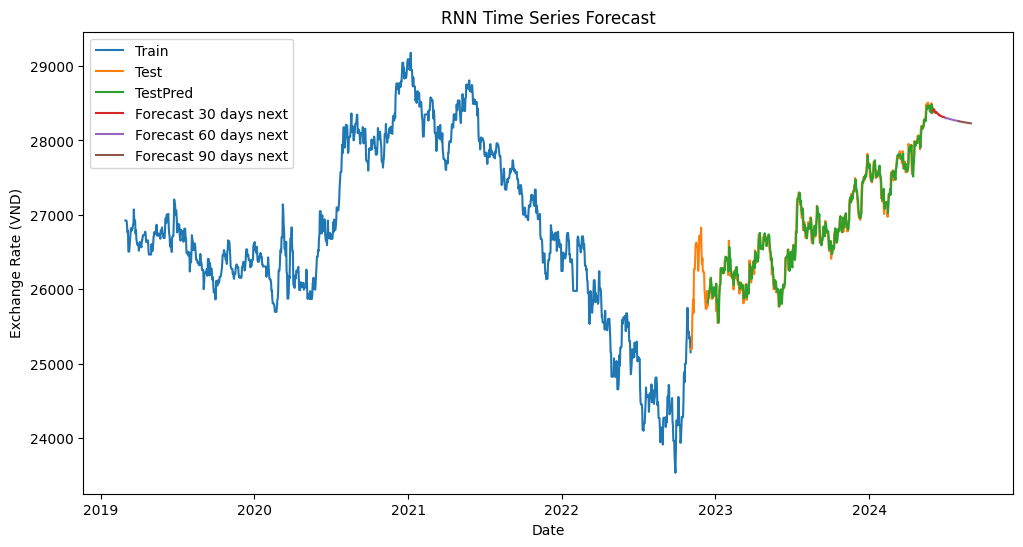

RMSE = 93.65460356603366
MAPE(%) = 0.2519947122598272
MAE = 67.51538085937523


In [25]:
a =implement_RNN(train_eur_1_sc, test_eur_1_sc)

- **Case 2. 8:2**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2613 - val_loss: 0.0074
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 9.9909e-04
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - v

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9117e-04 - val_loss: 3.0379e-04
Epoch 67/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8989e-04 - val_loss: 3.0370e-04
Epoch 68/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8863e-04 - val_loss: 3.0334e-04
Epoch 69/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8740e-04 - val_loss: 3.0256e-04
Epoch 70/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8617e-04 - val_loss: 3.0135e-04
Epoch 71/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8496e-04 - val_loss: 2.9978e-04
Epoch 72/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8380e-04 - val_loss: 2.9799e-04
Epoch 73/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8269e-04 - val_loss: 2.9613e-04
Epoch 74/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8165e-04 - val_loss: 2.9430e-04
Epoch 75/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8069e-04 - val_loss: 2.9256e-04
Epoch 76/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7981e-04 - 

8 day output [[0.8307216]]
9 day input [0.79652913 0.81565433 0.82574818 0.82574818 0.82415442 0.82149814
 0.82380025 0.82450859 0.839915   0.839915   0.839915   0.83832123
 0.84487338 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697
 0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.85986096 0.85751134 0.85378569 0.85206378 0.84528351
 0.8405326  0.83506018 0.83294147 0.83072162]
9 day output [[0.8257513]]
10 day input [0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.85986096 0.85751134 0.85378569 0.85206378 0.84528351 0.8405326
 0.83506018 0.83294147 0.83072162 0.8257513 ]
10 day output [[0.821552]]

26 day output [[0.7672106]]
27 day input [0.88153002 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356
 0.86187356 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195
 0.86683195 0.85986096 0.85751134 0.85378569 0.85206378 0.84528351
 0.8405326  0.83506018 0.83294147 0.83072162 0.8257513  0.82155198
 0.81881601 0.81483191 0.81041294 0.80783099 0.80365157 0.80082881
 0.79670209 0.79312962 0.7902981  0.78698856 0.78356946 0.78017223
 0.77632552 0.77354127 0.7705617  0.7672106 ]
27 day output [[0.76397973]]
28 day input [0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.85986096 0.85751134 0.85378569 0.85206378 0.84528351 0.8405326
 0.83506018 0.83294147 0.83072162 0.8257513  0.82155198 0.81881601
 0.81483191 0.81041294 0.80783099 0.80365157 0.80082881 0.79670209
 0.79312962 0.7902981  0.78698856 0.78356946 0.78017223 0.77632552
 0.77354127 0.7705617  0.7672106  0.76397973]
28 day output [[0.7607

45 day output [[0.7101025]]
46 day input [0.83506018 0.83294147 0.83072162 0.8257513  0.82155198 0.81881601
 0.81483191 0.81041294 0.80783099 0.80365157 0.80082881 0.79670209
 0.79312962 0.7902981  0.78698856 0.78356946 0.78017223 0.77632552
 0.77354127 0.7705617  0.7672106  0.76397973 0.76077431 0.75749588
 0.75396901 0.75105649 0.74847645 0.74530029 0.74211228 0.73917443
 0.73621452 0.7332558  0.7303375  0.72729492 0.72459364 0.72165364
 0.71872187 0.71571267 0.71287727 0.7101025 ]
46 day output [[0.707215]]
47 day input [0.83294147 0.83072162 0.8257513  0.82155198 0.81881601 0.81483191
 0.81041294 0.80783099 0.80365157 0.80082881 0.79670209 0.79312962
 0.7902981  0.78698856 0.78356946 0.78017223 0.77632552 0.77354127
 0.7705617  0.7672106  0.76397973 0.76077431 0.75749588 0.75396901
 0.75105649 0.74847645 0.74530029 0.74211228 0.73917443 0.73621452
 0.7332558  0.7303375  0.72729492 0.72459364 0.72165364 0.71872187
 0.71571267 0.71287727 0.7101025  0.70721501]
47 day output [[0.70434

62 day output [[0.6632227]]
63 day input [0.77632552 0.77354127 0.7705617  0.7672106  0.76397973 0.76077431
 0.75749588 0.75396901 0.75105649 0.74847645 0.74530029 0.74211228
 0.73917443 0.73621452 0.7332558  0.7303375  0.72729492 0.72459364
 0.72165364 0.71872187 0.71571267 0.71287727 0.7101025  0.70721501
 0.70434397 0.70157385 0.69875276 0.69595355 0.69316781 0.69039208
 0.68763751 0.68487245 0.68211371 0.67940199 0.67667317 0.67400634
 0.67127806 0.6685611  0.66588509 0.66322267]
63 day output [[0.6605522]]
64 day input [0.77354127 0.7705617  0.7672106  0.76397973 0.76077431 0.75749588
 0.75396901 0.75105649 0.74847645 0.74530029 0.74211228 0.73917443
 0.73621452 0.7332558  0.7303375  0.72729492 0.72459364 0.72165364
 0.71872187 0.71571267 0.71287727 0.7101025  0.70721501 0.70434397
 0.70157385 0.69875276 0.69595355 0.69316781 0.69039208 0.68763751
 0.68487245 0.68211371 0.67940199 0.67667317 0.67400634 0.67127806
 0.6685611  0.66588509 0.66322267 0.6605522 ]
64 day output [[0.6579

80 day output [[0.6164645]]
81 day input [0.72165364 0.71872187 0.71571267 0.71287727 0.7101025  0.70721501
 0.70434397 0.70157385 0.69875276 0.69595355 0.69316781 0.69039208
 0.68763751 0.68487245 0.68211371 0.67940199 0.67667317 0.67400634
 0.67127806 0.6685611  0.66588509 0.66322267 0.6605522  0.65790927
 0.65526122 0.65262789 0.64997125 0.64734656 0.64473611 0.64213574
 0.63953805 0.6369462  0.63435429 0.63178658 0.62921065 0.62664449
 0.62409198 0.62154871 0.61900526 0.6164645 ]
81 day output [[0.6139313]]
82 day input [0.71872187 0.71571267 0.71287727 0.7101025  0.70721501 0.70434397
 0.70157385 0.69875276 0.69595355 0.69316781 0.69039208 0.68763751
 0.68487245 0.68211371 0.67940199 0.67667317 0.67400634 0.67127806
 0.6685611  0.66588509 0.66322267 0.6605522  0.65790927 0.65526122
 0.65262789 0.64997125 0.64734656 0.64473611 0.64213574 0.63953805
 0.6369462  0.63435429 0.63178658 0.62921065 0.62664449 0.62409198
 0.62154871 0.61900526 0.6164645  0.6139313 ]
82 day output [[0.6114

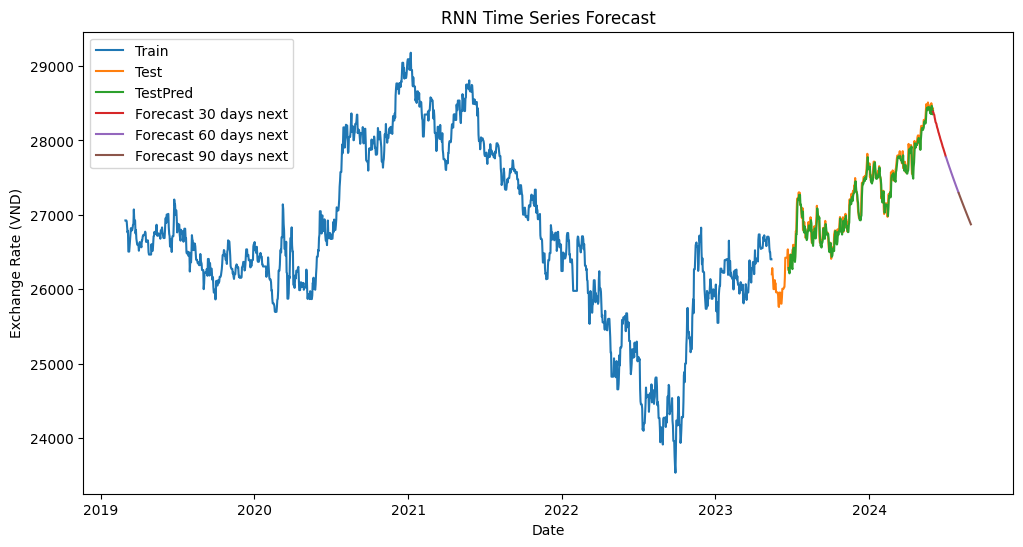

RMSE = 92.96153642154864
MAPE(%) = 0.2535475641794316
MAE = 69.08054937318325


In [26]:
implement_RNN(train_eur_2_sc, test_eur_2_sc)

- **Case 3. 9:1**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2478 - val_loss: 0.0191
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059 - val_loss: 0.0011
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 8.7600e-04
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 7.3456e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 6.7782e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 6.3720e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 5.9577e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 5.5350e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 5.2373e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8381e-04 - val_loss: 5.0872e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3473e-04 - val_loss: 4.8264e-04
Epoch 12/100
27/27 ━━━━━━━━━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1108e-04 - val_loss: 2.3608e-04
Epoch 66/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0921e-04 - val_loss: 2.3504e-04
Epoch 67/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0738e-04 - val_loss: 2.3403e-04
Epoch 68/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0560e-04 - val_loss: 2.3304e-04
Epoch 69/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0386e-04 - val_loss: 2.3208e-04
Epoch 70/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0216e-04 - val_loss: 2.3114e-04
Epoch 71/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0050e-04 - val_loss: 2.3022e-04
Epoch 72/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9887e-04 - val_loss: 2.2932e-04
Epoch 73/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9728e-04 - val_loss: 2.2844e-04
Epoch 74/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9572e-04 - val_loss: 2.2757e-04
Epoch 75/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9420e-04 - 

9 day output [[0.84194785]]
10 day input [0.81565433 0.82574818 0.82574818 0.82415442 0.82149814 0.82380025
 0.82450859 0.839915   0.839915   0.839915   0.83832123 0.84487338
 0.86116522 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002
 0.87515495 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356
 0.87267576 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195
 0.86372471 0.86235702 0.85978985 0.85880017 0.85430622 0.85108167
 0.84727186 0.84629297 0.84536594 0.84194785]
10 day output [[0.83903813]]
11 day input [0.82574818 0.82574818 0.82415442 0.82149814 0.82380025 0.82450859
 0.839915   0.839915   0.839915   0.83832123 0.84487338 0.86116522
 0.87745706 0.86895697 0.86895697 0.86895697 0.88153002 0.87515495
 0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.86372471
 0.86235702 0.85978985 0.85880017 0.85430622 0.85108167 0.84727186
 0.84629297 0.84536594 0.84194785 0.83903813]
11 day output [[0.838

28 day output [[0.8052902]]
29 day input [0.87497786 0.87090491 0.86187356 0.86187356 0.86187356 0.87267576
 0.87975916 0.87267576 0.85567558 0.86683195 0.86683195 0.86372471
 0.86235702 0.85978985 0.85880017 0.85430622 0.85108167 0.84727186
 0.84629297 0.84536594 0.84194785 0.83903813 0.83812606 0.83545905
 0.83238441 0.83071542 0.828067   0.82694376 0.82414794 0.82217032
 0.82073522 0.81868744 0.81692439 0.81513518 0.81282252 0.81177199
 0.81046093 0.80867213 0.80685431 0.80529022]
29 day output [[0.80373585]]
30 day input [0.87090491 0.86187356 0.86187356 0.86187356 0.87267576 0.87975916
 0.87267576 0.85567558 0.86683195 0.86683195 0.86372471 0.86235702
 0.85978985 0.85880017 0.85430622 0.85108167 0.84727186 0.84629297
 0.84536594 0.84194785 0.83903813 0.83812606 0.83545905 0.83238441
 0.83071542 0.828067   0.82694376 0.82414794 0.82217032 0.82073522
 0.81868744 0.81692439 0.81513518 0.81282252 0.81177199 0.81046093
 0.80867213 0.80685431 0.80529022 0.80373585]
30 day output [[0.801

45 day output [[0.7836999]]
46 day input [0.84727186 0.84629297 0.84536594 0.84194785 0.83903813 0.83812606
 0.83545905 0.83238441 0.83071542 0.828067   0.82694376 0.82414794
 0.82217032 0.82073522 0.81868744 0.81692439 0.81513518 0.81282252
 0.81177199 0.81046093 0.80867213 0.80685431 0.80529022 0.80373585
 0.80168456 0.80037701 0.79950076 0.79790223 0.79647297 0.7951628
 0.79371428 0.79264343 0.79147637 0.79020047 0.78914917 0.78804523
 0.78696817 0.78570008 0.78463846 0.78369993]
46 day output [[0.7825899]]
47 day input [0.84629297 0.84536594 0.84194785 0.83903813 0.83812606 0.83545905
 0.83238441 0.83071542 0.828067   0.82694376 0.82414794 0.82217032
 0.82073522 0.81868744 0.81692439 0.81513518 0.81282252 0.81177199
 0.81046093 0.80867213 0.80685431 0.80529022 0.80373585 0.80168456
 0.80037701 0.79950076 0.79790223 0.79647297 0.7951628  0.79371428
 0.79264343 0.79147637 0.79020047 0.78914917 0.78804523 0.78696817
 0.78570008 0.78463846 0.78369993 0.78258991]
47 day output [[0.78156

63 day output [[0.7678141]]
64 day input [0.81177199 0.81046093 0.80867213 0.80685431 0.80529022 0.80373585
 0.80168456 0.80037701 0.79950076 0.79790223 0.79647297 0.7951628
 0.79371428 0.79264343 0.79147637 0.79020047 0.78914917 0.78804523
 0.78696817 0.78570008 0.78463846 0.78369993 0.78258991 0.78156114
 0.78063542 0.77964437 0.77871001 0.7777459  0.77681637 0.77592325
 0.77501208 0.77419084 0.77332133 0.7724691  0.77171129 0.77087045
 0.77004695 0.76929891 0.76855284 0.7678141 ]
64 day output [[0.7670831]]
65 day input [0.81046093 0.80867213 0.80685431 0.80529022 0.80373585 0.80168456
 0.80037701 0.79950076 0.79790223 0.79647297 0.7951628  0.79371428
 0.79264343 0.79147637 0.79020047 0.78914917 0.78804523 0.78696817
 0.78570008 0.78463846 0.78369993 0.78258991 0.78156114 0.78063542
 0.77964437 0.77871001 0.7777459  0.77681637 0.77592325 0.77501208
 0.77419084 0.77332133 0.7724691  0.77171129 0.77087045 0.77004695
 0.76929891 0.76855284 0.7678141  0.76708311]
65 day output [[0.76637

80 day output [[0.7569941]]
81 day input [0.78804523 0.78696817 0.78570008 0.78463846 0.78369993 0.78258991
 0.78156114 0.78063542 0.77964437 0.77871001 0.7777459  0.77681637
 0.77592325 0.77501208 0.77419084 0.77332133 0.7724691  0.77171129
 0.77087045 0.77004695 0.76929891 0.76855284 0.7678141  0.76708311
 0.76637667 0.76567161 0.76495165 0.7642839  0.76361096 0.76294827
 0.76232678 0.76168221 0.76104677 0.76044458 0.75984198 0.75924981
 0.75866657 0.75810498 0.75755286 0.75699413]
81 day output [[0.7564592]]
82 day input [0.78696817 0.78570008 0.78463846 0.78369993 0.78258991 0.78156114
 0.78063542 0.77964437 0.77871001 0.7777459  0.77681637 0.77592325
 0.77501208 0.77419084 0.77332133 0.7724691  0.77171129 0.77087045
 0.77004695 0.76929891 0.76855284 0.7678141  0.76708311 0.76637667
 0.76567161 0.76495165 0.7642839  0.76361096 0.76294827 0.76232678
 0.76168221 0.76104677 0.76044458 0.75984198 0.75924981 0.75866657
 0.75810498 0.75755286 0.75699413 0.75645918]
82 day output [[0.7559

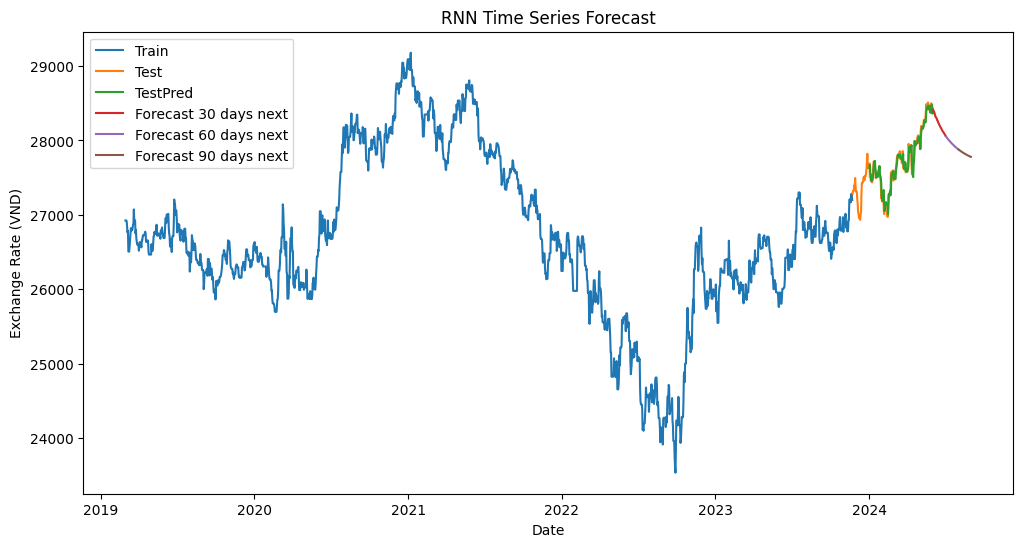

RMSE = 81.73817627545121
MAPE(%) = 0.20463466536689723
MAE = 56.66665810032928


In [27]:
implement_RNN(train_eur_3_sc, test_eur_3_sc)

# GBP - VND



In [28]:
# Scale data
gbp_sc = scaler.fit_transform(np.array(gbp).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_gbp_1_sc = gbp_sc[:int(0.7*len(gbp))]
test_gbp_1_sc = gbp_sc[int(0.7*len(gbp)):]
 ## case 2. 8:2
train_gbp_2_sc = gbp_sc[:int(0.8*len(gbp))]
test_gbp_2_sc = gbp_sc[int(0.8*len(gbp)):]
 ## case 3. 9:1
train_gbp_3_sc = gbp_sc[:int(0.9*len(gbp))]
test_gbp_3_sc = gbp_sc[int(0.9*len(gbp)):]

- **Case 1. 7:3**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3154 - val_loss: 0.0128
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0021
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 9.5494e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 9.8585e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 9.8001e-04
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9922e-04 - val_loss: 3.1663e-04
Epoch 67/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9702e-04 - val_loss: 3.1808e-04
Epoch 68/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9476e-04 - val_loss: 3.1975e-04
Epoch 69/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9240e-04 - val_loss: 3.2146e-04
Epoch 70/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8993e-04 - val_loss: 3.2301e-04
Epoch 71/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8733e-04 - val_loss: 3.2424e-04
Epoch 72/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8460e-04 - val_loss: 3.2502e-04
Epoch 73/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8177e-04 - val_loss: 3.2528e-04
Epoch 74/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7887e-04 - val_loss: 3.2505e-04
Epoch 75/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7595e-04 - val_loss: 3.2439e-04
Epoch 76/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7306e-04 - 

8 day output [[0.97248167]]
9 day input [0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.96872795 0.96899307 0.96848577 0.97175616 0.97083634
 0.96976376 0.96862614 0.96975034 0.97248167]
9 day output [[0.973038]]
10 day input [0.91195741 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239
 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641
 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847
 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147
 0.96872795 0.96899307 0.96848577 0.97175616 0.97083634 0.96976376
 0.96862614 0.96975034 0.97248167 0.97303802]
10 day output [[0.97350496

28 day output [[0.976594]]
29 day input [0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.96872795
 0.96899307 0.96848577 0.97175616 0.97083634 0.96976376 0.96862614
 0.96975034 0.97248167 0.97303802 0.97350496 0.97336084 0.97372723
 0.97283679 0.97402823 0.97340918 0.97472036 0.97441393 0.97457474
 0.97469121 0.97517323 0.97546887 0.97549641 0.97562593 0.97561681
 0.97611845 0.97600478 0.97651219 0.97659397]
29 day output [[0.97691065]]
30 day input [0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.98826099 0.97229047 0.97147147 0.97147147 0.96872795 0.96899307
 0.96848577 0.97175616 0.97083634 0.96976376 0.96862614 0.96975034
 0.97248167 0.97303802 0.97350496 0.97336084 0.97372723 0.97283679
 0.97402823 0.97340918 0.97472036 0.97441393 0.97457474 0.97469121
 0.97517323 0.97546887 0.97549641 0.97562593 0.97561681 0.97611845
 0.97600478 0.97651219 0.97659397 0.97691065]
30 day output [[0.9771

47 day output [[0.9807454]]
48 day input [0.97248167 0.97303802 0.97350496 0.97336084 0.97372723 0.97283679
 0.97402823 0.97340918 0.97472036 0.97441393 0.97457474 0.97469121
 0.97517323 0.97546887 0.97549641 0.97562593 0.97561681 0.97611845
 0.97600478 0.97651219 0.97659397 0.97691065 0.9771471  0.97727048
 0.97783023 0.97790802 0.97829908 0.97834748 0.97876072 0.97881269
 0.97905588 0.97916079 0.97942477 0.97964853 0.97977746 0.98000938
 0.98009735 0.98039532 0.98051906 0.98074538]
48 day output [[0.9809029]]
49 day input [0.97303802 0.97350496 0.97336084 0.97372723 0.97283679 0.97402823
 0.97340918 0.97472036 0.97441393 0.97457474 0.97469121 0.97517323
 0.97546887 0.97549641 0.97562593 0.97561681 0.97611845 0.97600478
 0.97651219 0.97659397 0.97691065 0.9771471  0.97727048 0.97783023
 0.97790802 0.97829908 0.97834748 0.97876072 0.97881269 0.97905588
 0.97916079 0.97942477 0.97964853 0.97977746 0.98000938 0.98009735
 0.98039532 0.98051906 0.98074538 0.98090291]
49 day output [[0.9811

67 day output [[0.98409325]]
68 day input [0.97659397 0.97691065 0.9771471  0.97727048 0.97783023 0.97790802
 0.97829908 0.97834748 0.97876072 0.97881269 0.97905588 0.97916079
 0.97942477 0.97964853 0.97977746 0.98000938 0.98009735 0.98039532
 0.98051906 0.98074538 0.98090291 0.98110908 0.98127669 0.98144287
 0.98163098 0.98178577 0.98200464 0.98213029 0.98234314 0.98247492
 0.982678   0.98282313 0.98299319 0.98315573 0.98330903 0.98347914
 0.98361605 0.98378807 0.98392266 0.98409325]
68 day output [[0.98422587]]
69 day input [0.97691065 0.9771471  0.97727048 0.97783023 0.97790802 0.97829908
 0.97834748 0.97876072 0.97881269 0.97905588 0.97916079 0.97942477
 0.97964853 0.97977746 0.98000938 0.98009735 0.98039532 0.98051906
 0.98074538 0.98090291 0.98110908 0.98127669 0.98144287 0.98163098
 0.98178577 0.98200464 0.98213029 0.98234314 0.98247492 0.982678
 0.98282313 0.98299319 0.98315573 0.98330903 0.98347914 0.98361605
 0.98378807 0.98392266 0.98409325 0.98422587]
69 day output [[0.9843

87 day output [[0.9868332]]
88 day input [0.98090291 0.98110908 0.98127669 0.98144287 0.98163098 0.98178577
 0.98200464 0.98213029 0.98234314 0.98247492 0.982678   0.98282313
 0.98299319 0.98315573 0.98330903 0.98347914 0.98361605 0.98378807
 0.98392266 0.98409325 0.98422587 0.98438805 0.98452884 0.98467642
 0.98482525 0.98496187 0.98511428 0.98524392 0.98539287 0.98552173
 0.98566628 0.98579538 0.98593253 0.98606294 0.98619372 0.98632616
 0.98645037 0.98658264 0.98670352 0.98683321]
88 day output [[0.98695225]]
89 day input [0.98110908 0.98127669 0.98144287 0.98163098 0.98178577 0.98200464
 0.98213029 0.98234314 0.98247492 0.982678   0.98282313 0.98299319
 0.98315573 0.98330903 0.98347914 0.98361605 0.98378807 0.98392266
 0.98409325 0.98422587 0.98438805 0.98452884 0.98467642 0.98482525
 0.98496187 0.98511428 0.98524392 0.98539287 0.98552173 0.98566628
 0.98579538 0.98593253 0.98606294 0.98619372 0.98632616 0.98645037
 0.98658264 0.98670352 0.98683321 0.98695225]
89 day output [[0.987

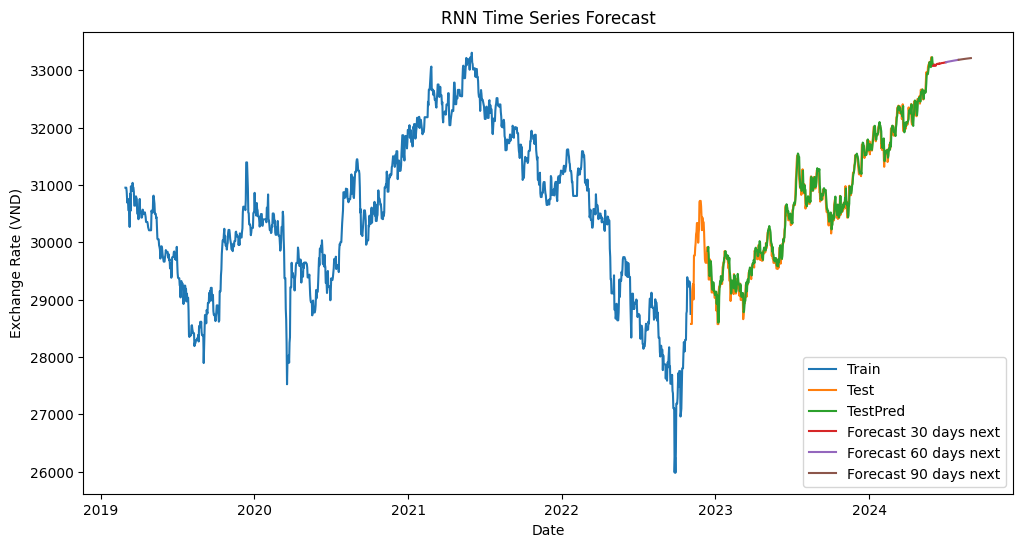

RMSE = 125.43789592931473
MAPE(%) = 0.297369495474632
MAE = 90.84692018423506


In [29]:
implement_RNN(train_gbp_1_sc, test_gbp_1_sc)

- **Case 2. 8:2**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2668 - val_loss: 0.0136
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0030
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_l

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6498e-04 - val_loss: 3.8790e-04
Epoch 67/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6123e-04 - val_loss: 3.8025e-04
Epoch 68/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5771e-04 - val_loss: 3.7304e-04
Epoch 69/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5441e-04 - val_loss: 3.6634e-04
Epoch 70/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5133e-04 - val_loss: 3.6018e-04
Epoch 71/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4847e-04 - val_loss: 3.5453e-04
Epoch 72/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4580e-04 - val_loss: 3.4936e-04
Epoch 73/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4331e-04 - val_loss: 3.4463e-04
Epoch 74/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4097e-04 - val_loss: 3.4028e-04
Epoch 75/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3878e-04 - val_loss: 3.3626e-04
Epoch 76/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3671e-04 - 

8 day output [[0.9359771]]
9 day input [0.8953044  0.91195741 0.90827191 0.90827191 0.91263991 0.9033579
 0.89148239 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891
 0.91004641 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295
 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.96430218 0.96146703 0.95648241 0.95496154 0.94996703
 0.94510007 0.93971723 0.93694508 0.9359771 ]
9 day output [[0.93236756]]
10 day input [0.91195741 0.90827191 0.90827191 0.91263991 0.9033579  0.89148239
 0.88861589 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641
 0.93147693 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847
 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647
 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147
 0.96430218 0.96146703 0.95648241 0.95496154 0.94996703 0.94510007
 0.93971723 0.93694508 0.9359771  0.93236756]
10 day output [[0.9292914

25 day output [[0.8860556]]
26 day input [0.94840295 0.96573847 0.97078897 0.97215397 0.97734098 0.97010647
 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.96430218 0.96146703 0.95648241 0.95496154
 0.94996703 0.94510007 0.93971723 0.93694508 0.9359771  0.93236756
 0.92929143 0.9259454  0.92370743 0.9194814  0.9176985  0.91360086
 0.91154617 0.90817618 0.9052121  0.90271592 0.90005195 0.89739919
 0.8939535  0.89129615 0.88815665 0.88605559]
26 day output [[0.88296026]]
27 day input [0.96573847 0.97078897 0.97215397 0.97734098 0.97010647 0.97010647
 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047 0.97147147
 0.97147147 0.96430218 0.96146703 0.95648241 0.95496154 0.94996703
 0.94510007 0.93971723 0.93694508 0.9359771  0.93236756 0.92929143
 0.9259454  0.92370743 0.9194814  0.9176985  0.91360086 0.91154617
 0.90817618 0.9052121  0.90271592 0.90005195 0.89739919 0.8939535
 0.89129615 0.88815665 0.88605559 0.88296026]
27 day output [[0.8803

42 day output [[0.83772254]]
43 day input [0.95496154 0.94996703 0.94510007 0.93971723 0.93694508 0.9359771
 0.93236756 0.92929143 0.9259454  0.92370743 0.9194814  0.9176985
 0.91360086 0.91154617 0.90817618 0.9052121  0.90271592 0.90005195
 0.89739919 0.8939535  0.89129615 0.88815665 0.88605559 0.88296026
 0.88035423 0.87738144 0.87445647 0.87173557 0.86856586 0.86638761
 0.86338186 0.86078602 0.85764688 0.85503227 0.85205483 0.84920287
 0.84640485 0.84348869 0.84076959 0.83772254]
43 day output [[0.8349483]]
44 day input [0.94996703 0.94510007 0.93971723 0.93694508 0.9359771  0.93236756
 0.92929143 0.9259454  0.92370743 0.9194814  0.9176985  0.91360086
 0.91154617 0.90817618 0.9052121  0.90271592 0.90005195 0.89739919
 0.8939535  0.89129615 0.88815665 0.88605559 0.88296026 0.88035423
 0.87738144 0.87445647 0.87173557 0.86856586 0.86638761 0.86338186
 0.86078602 0.85764688 0.85503227 0.85205483 0.84920287 0.84640485
 0.84348869 0.84076959 0.83772254 0.8349483 ]
44 day output [[0.83185

60 day output [[0.7850141]]
61 day input [0.89739919 0.8939535  0.89129615 0.88815665 0.88605559 0.88296026
 0.88035423 0.87738144 0.87445647 0.87173557 0.86856586 0.86638761
 0.86338186 0.86078602 0.85764688 0.85503227 0.85205483 0.84920287
 0.84640485 0.84348869 0.84076959 0.83772254 0.8349483  0.83185017
 0.82913655 0.82617557 0.82328808 0.82036954 0.81744379 0.81458479
 0.8115831  0.80872935 0.80569744 0.80284446 0.79981053 0.79692155
 0.79393917 0.79099303 0.78803092 0.78501409]
61 day output [[0.7820668]]
62 day input [0.8939535  0.89129615 0.88815665 0.88605559 0.88296026 0.88035423
 0.87738144 0.87445647 0.87173557 0.86856586 0.86638761 0.86338186
 0.86078602 0.85764688 0.85503227 0.85205483 0.84920287 0.84640485
 0.84348869 0.84076959 0.83772254 0.8349483  0.83185017 0.82913655
 0.82617557 0.82328808 0.82036954 0.81744379 0.81458479 0.8115831
 0.80872935 0.80569744 0.80284446 0.79981053 0.79692155 0.79393917
 0.79099303 0.78803092 0.78501409 0.78206682]
62 day output [[0.77903

80 day output [[0.72424]]
81 day input [0.84076959 0.83772254 0.8349483  0.83185017 0.82913655 0.82617557
 0.82328808 0.82036954 0.81744379 0.81458479 0.8115831  0.80872935
 0.80569744 0.80284446 0.79981053 0.79692155 0.79393917 0.79099303
 0.78803092 0.78501409 0.78206682 0.77903038 0.77610356 0.77305585
 0.77008981 0.76705027 0.76404691 0.76100701 0.75797129 0.75496161
 0.75189537 0.74887681 0.7457912  0.74275625 0.73966378 0.73660678
 0.7335192  0.73043495 0.7273488  0.72424001]
81 day output [[0.72114694]]
82 day input [0.83772254 0.8349483  0.83185017 0.82913655 0.82617557 0.82328808
 0.82036954 0.81744379 0.81458479 0.8115831  0.80872935 0.80569744
 0.80284446 0.79981053 0.79692155 0.79393917 0.79099303 0.78803092
 0.78501409 0.78206682 0.77903038 0.77610356 0.77305585 0.77008981
 0.76705027 0.76404691 0.76100701 0.75797129 0.75496161 0.75189537
 0.74887681 0.7457912  0.74275625 0.73966378 0.73660678 0.7335192
 0.73043495 0.7273488  0.72424001 0.72114694]
82 day output [[0.718019

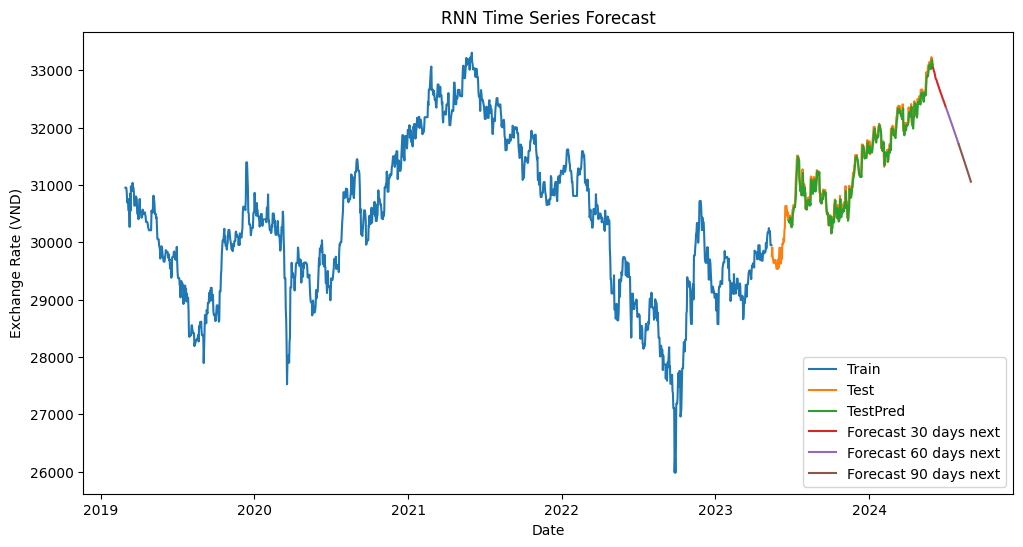

RMSE = 122.7891981190054
MAPE(%) = 0.2940242701448922
MAE = 92.39521257267442


In [30]:
implement_RNN(train_gbp_2_sc, test_gbp_2_sc)

- **Case 3. 9:1**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2704 - val_loss: 0.0381
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 8.8835e-04
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 8.8509e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 6.7786e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 5.3544e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 4.7696e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 4.4272e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 4.1684e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 3.9513e-04
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4863e-04 - val_loss: 2.3469e-04
Epoch 66/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4598e-04 - val_loss: 2.3433e-04
Epoch 67/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4342e-04 - val_loss: 2.3394e-04
Epoch 68/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4093e-04 - val_loss: 2.3352e-04
Epoch 69/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3852e-04 - val_loss: 2.3307e-04
Epoch 70/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3619e-04 - val_loss: 2.3260e-04
Epoch 71/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3394e-04 - val_loss: 2.3212e-04
Epoch 72/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3176e-04 - val_loss: 2.3162e-04
Epoch 73/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2965e-04 - val_loss: 2.3110e-04
Epoch 74/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2763e-04 - val_loss: 2.3058e-04
Epoch 75/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2567e-04 - 

10 day output [[0.9623553]]
11 day input [0.90827191 0.90827191 0.91263991 0.9033579  0.89148239 0.88861589
 0.90745291 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693
 0.95345345 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897
 0.97215397 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048
 0.98948949 0.98826099 0.97229047 0.97147147 0.97147147 0.96830392
 0.96818095 0.96575272 0.96758157 0.96595901 0.96430039 0.96153814
 0.96154112 0.96319383 0.96255285 0.96235532]
11 day output [[0.96154344]]
12 day input [0.90827191 0.91263991 0.9033579  0.89148239 0.88861589 0.90745291
 0.90745291 0.90745291 0.90526891 0.91004641 0.93147693 0.95345345
 0.94840295 0.94840295 0.94840295 0.96573847 0.97078897 0.97215397
 0.97734098 0.97010647 0.97010647 0.97010647 0.98321048 0.98948949
 0.98826099 0.97229047 0.97147147 0.97147147 0.96830392 0.96818095
 0.96575272 0.96758157 0.96595901 0.96430039 0.96153814 0.96154112
 0.96319383 0.96255285 0.96235532 0.96154344]
12 day output [[0.961

30 day output [[0.94776326]]
31 day input [0.97010647 0.97010647 0.97010647 0.98321048 0.98948949 0.98826099
 0.97229047 0.97147147 0.97147147 0.96830392 0.96818095 0.96575272
 0.96758157 0.96595901 0.96430039 0.96153814 0.96154112 0.96319383
 0.96255285 0.96235532 0.96154344 0.96144414 0.9593187  0.95955902
 0.95740968 0.9577387  0.9565829  0.95563197 0.95492148 0.95421314
 0.95362717 0.95239413 0.9517712  0.95082319 0.95084029 0.94983119
 0.94943708 0.94875002 0.94822204 0.94776326]
31 day output [[0.9468732]]
32 day input [0.97010647 0.97010647 0.98321048 0.98948949 0.98826099 0.97229047
 0.97147147 0.97147147 0.96830392 0.96818095 0.96575272 0.96758157
 0.96595901 0.96430039 0.96153814 0.96154112 0.96319383 0.96255285
 0.96235532 0.96154344 0.96144414 0.9593187  0.95955902 0.95740968
 0.9577387  0.9565829  0.95563197 0.95492148 0.95421314 0.95362717
 0.95239413 0.9517712  0.95082319 0.95084029 0.94983119 0.94943708
 0.94875002 0.94822204 0.94776326 0.94687319]
32 day output [[0.946

50 day output [[0.9370892]]
51 day input [0.96154344 0.96144414 0.9593187  0.95955902 0.95740968 0.9577387
 0.9565829  0.95563197 0.95492148 0.95421314 0.95362717 0.95239413
 0.9517712  0.95082319 0.95084029 0.94983119 0.94943708 0.94875002
 0.94822204 0.94776326 0.94687319 0.94688171 0.94615829 0.94592041
 0.94509834 0.94477153 0.94409549 0.94361496 0.94301635 0.94241065
 0.94199008 0.94130993 0.94088376 0.9401148  0.93973756 0.93912077
 0.93862379 0.93808711 0.93755698 0.9370892 ]
51 day output [[0.9365124]]
52 day input [0.96144414 0.9593187  0.95955902 0.95740968 0.9577387  0.9565829
 0.95563197 0.95492148 0.95421314 0.95362717 0.95239413 0.9517712
 0.95082319 0.95084029 0.94983119 0.94943708 0.94875002 0.94822204
 0.94776326 0.94687319 0.94688171 0.94615829 0.94592041 0.94509834
 0.94477153 0.94409549 0.94361496 0.94301635 0.94241065 0.94199008
 0.94130993 0.94088376 0.9401148  0.93973756 0.93912077 0.93862379
 0.93808711 0.93755698 0.9370892  0.93651241]
52 day output [[0.9360675

70 day output [[0.927024]]
71 day input [0.94687319 0.94688171 0.94615829 0.94592041 0.94509834 0.94477153
 0.94409549 0.94361496 0.94301635 0.94241065 0.94199008 0.94130993
 0.94088376 0.9401148  0.93973756 0.93912077 0.93862379 0.93808711
 0.93755698 0.9370892  0.93651241 0.93606752 0.93546319 0.93505508
 0.93446261 0.93402314 0.93346715 0.93298882 0.93248856 0.93195397
 0.93148166 0.93093616 0.93049067 0.92994046 0.92948174 0.92895758
 0.92848921 0.92798233 0.92749441 0.92702401]
71 day output [[0.92651993]]
72 day input [0.94688171 0.94615829 0.94592041 0.94509834 0.94477153 0.94409549
 0.94361496 0.94301635 0.94241065 0.94199008 0.94130993 0.94088376
 0.9401148  0.93973756 0.93912077 0.93862379 0.93808711 0.93755698
 0.9370892  0.93651241 0.93606752 0.93546319 0.93505508 0.93446261
 0.93402314 0.93346715 0.93298882 0.93248856 0.93195397 0.93148166
 0.93093616 0.93049067 0.92994046 0.92948174 0.92895758 0.92848921
 0.92798233 0.92749441 0.92702401 0.92651993]
72 day output [[0.9260

90 day output [[0.9177521]]


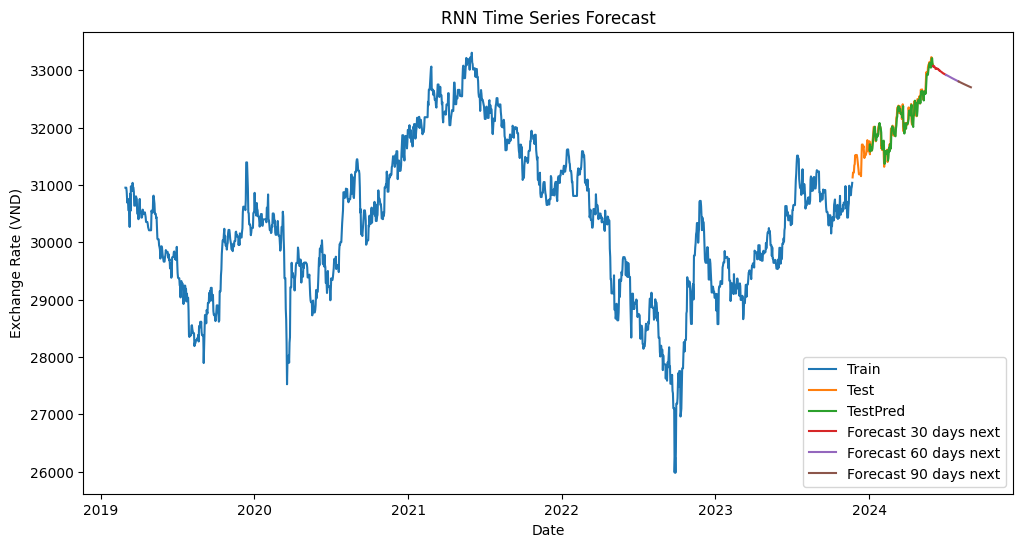

RMSE = 105.79690190608258
MAPE(%) = 0.23396866402329242
MAE = 75.1463430304279


In [31]:
implement_RNN(train_gbp_3_sc, test_gbp_3_sc)

# JPY - VND

In [32]:
# Scale data
jpy_sc = scaler.fit_transform(np.array(jpy).reshape(-1,1))
# Split train, test data
 ## case 1. 7:3
train_jpy_1_sc = jpy_sc[:int(0.7*len(jpy))]
test_jpy_1_sc = jpy_sc[int(0.7*len(jpy)):]
 ## case 2. 8:2
train_jpy_2_sc = jpy_sc[:int(0.8*len(jpy))]
test_jpy_2_sc = jpy_sc[int(0.8*len(jpy)):]
 ## case 3. 9:1
train_jpy_3_sc = jpy_sc[:int(0.9*len(jpy))]
test_jpy_3_sc = jpy_sc[int(0.9*len(jpy)):]

- **Case 1. 7:3**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4516 - val_loss: 0.0134
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0084
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8081e-04 - val_loss: 0.0012
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4237e-04 - val_loss: 0.0013
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.1152e-04 - val_loss: 0.0013
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7107e-04 - val_loss: 0.0012
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2426e-04 - val_loss: 0.0011
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1720e-04 - val_loss: 3.6192e-04
Epoch 66/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1467e-04 - val_loss: 3.5962e-04
Epoch 67/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1221e-04 - val_loss: 3.5745e-04
Epoch 68/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0982e-04 - val_loss: 3.5540e-04
Epoch 69/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0750e-04 - val_loss: 3.5348e-04
Epoch 70/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0523e-04 - val_loss: 3.5167e-04
Epoch 71/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0304e-04 - val_loss: 3.4997e-04
Epoch 72/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0090e-04 - val_loss: 3.4839e-04
Epoch 73/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9883e-04 - val_loss: 3.4691e-04
Epoch 74/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9681e-04 - val_loss: 3.4552e-04
Epoch 75/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9486e-04 - 

8 day output [[0.07658765]]
9 day input [0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.01668109 0.01711463 0.01937086 0.03277561 0.04239757
 0.04977583 0.06261253 0.07502244 0.07658765]
9 day output [[0.08113529]]
10 day input [0.08728379 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874
 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444
 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.01668109 0.01711463 0.01937086 0.03277561 0.04239757 0.04977583
 0.06261253 0.07502244 0.07658765 0.08113529]
10 day output [[0.086533

27 day output [[0.15213634]]
28 day input [0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.01668109 0.01711463 0.01937086 0.03277561 0.04239757 0.04977583
 0.06261253 0.07502244 0.07658765 0.08113529 0.08653311 0.09146378
 0.09806269 0.10197978 0.10516363 0.11142294 0.11858034 0.12393767
 0.12662227 0.13373302 0.13940321 0.14104246 0.1406641  0.14370666
 0.14522968 0.14658102 0.14780511 0.15213634]
28 day output [[0.15549292]]
29 day input [0.03619475 0.0318706  0.02674568 0.02674568 0.02674568 0.02834721
 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937 0.01668109
 0.01711463 0.01937086 0.03277561 0.04239757 0.04977583 0.06261253
 0.07502244 0.07658765 0.08113529 0.08653311 0.09146378 0.09806269
 0.10197978 0.10516363 0.11142294 0.11858034 0.12393767 0.12662227
 0.13373302 0.13940321 0.14104246 0.1406641  0.14370666 0.14522968
 0.14658102 0.14780511 0.15213634 0.15549292]
29 day output [[0.15

47 day output [[0.10396776]]
48 day input [0.07658765 0.08113529 0.08653311 0.09146378 0.09806269 0.10197978
 0.10516363 0.11142294 0.11858034 0.12393767 0.12662227 0.13373302
 0.13940321 0.14104246 0.1406641  0.14370666 0.14522968 0.14658102
 0.14780511 0.15213634 0.15549292 0.15650067 0.15823957 0.15800032
 0.15557055 0.1531828  0.14799146 0.14274979 0.13922134 0.13528746
 0.13047867 0.12770054 0.12621985 0.12385011 0.11970552 0.1173083
 0.11455946 0.11097557 0.10744396 0.10396776]
48 day output [[0.10142375]]
49 day input [0.08113529 0.08653311 0.09146378 0.09806269 0.10197978 0.10516363
 0.11142294 0.11858034 0.12393767 0.12662227 0.13373302 0.13940321
 0.14104246 0.1406641  0.14370666 0.14522968 0.14658102 0.14780511
 0.15213634 0.15549292 0.15650067 0.15823957 0.15800032 0.15557055
 0.1531828  0.14799146 0.14274979 0.13922134 0.13528746 0.13047867
 0.12770054 0.12621985 0.12385011 0.11970552 0.1173083  0.11455946
 0.11097557 0.10744396 0.10396776 0.10142375]
49 day output [[0.099

67 day output [[0.09627204]]
68 day input [0.15549292 0.15650067 0.15823957 0.15800032 0.15557055 0.1531828
 0.14799146 0.14274979 0.13922134 0.13528746 0.13047867 0.12770054
 0.12621985 0.12385011 0.11970552 0.1173083  0.11455946 0.11097557
 0.10744396 0.10396776 0.10142375 0.09973065 0.09741993 0.09586247
 0.09521775 0.09499379 0.09431653 0.09265444 0.09162564 0.09107909
 0.089173   0.08765825 0.08732758 0.08779804 0.08822656 0.08912219
 0.09101386 0.09300805 0.09458742 0.09627204]
68 day output [[0.09755321]]
69 day input [0.15650067 0.15823957 0.15800032 0.15557055 0.1531828  0.14799146
 0.14274979 0.13922134 0.13528746 0.13047867 0.12770054 0.12621985
 0.12385011 0.11970552 0.1173083  0.11455946 0.11097557 0.10744396
 0.10396776 0.10142375 0.09973065 0.09741993 0.09586247 0.09521775
 0.09499379 0.09431653 0.09265444 0.09162564 0.09107909 0.089173
 0.08765825 0.08732758 0.08779804 0.08822656 0.08912219 0.09101386
 0.09300805 0.09458742 0.09627204 0.09755321]
69 day output [[0.09911

87 day output [[0.12012596]]
88 day input [0.10142375 0.09973065 0.09741993 0.09586247 0.09521775 0.09499379
 0.09431653 0.09265444 0.09162564 0.09107909 0.089173   0.08765825
 0.08732758 0.08779804 0.08822656 0.08912219 0.09101386 0.09300805
 0.09458742 0.09627204 0.09755321 0.0991101  0.10069016 0.10155477
 0.10292039 0.10499386 0.1068365  0.10851968 0.11026151 0.11238001
 0.11403909 0.11492848 0.11581682 0.11670227 0.11727137 0.11767635
 0.11795517 0.11868157 0.11953241 0.12012596]
88 day output [[0.12066827]]
89 day input [0.09973065 0.09741993 0.09586247 0.09521775 0.09499379 0.09431653
 0.09265444 0.09162564 0.09107909 0.089173   0.08765825 0.08732758
 0.08779804 0.08822656 0.08912219 0.09101386 0.09300805 0.09458742
 0.09627204 0.09755321 0.0991101  0.10069016 0.10155477 0.10292039
 0.10499386 0.1068365  0.10851968 0.11026151 0.11238001 0.11403909
 0.11492848 0.11581682 0.11670227 0.11727137 0.11767635 0.11795517
 0.11868157 0.11953241 0.12012596 0.12066827]
89 day output [[0.12

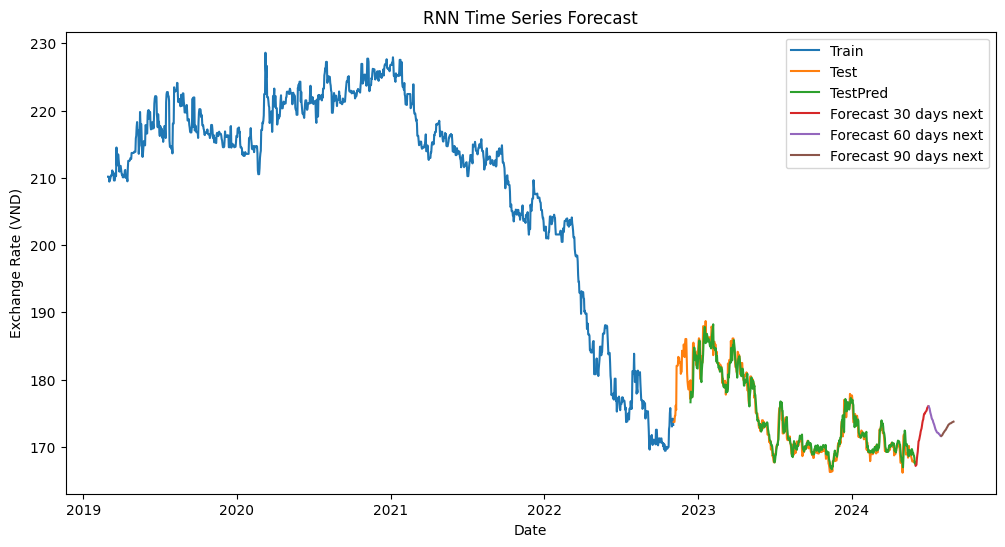

RMSE = 1.1188887161191075
MAPE(%) = 0.44357667942853823
MAE = 0.7786258458379488


In [33]:
implement_RNN(train_jpy_1_sc, test_jpy_1_sc)

- **Case 2. 8:2**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3836 - val_loss: 0.0544
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - val_loss: 9.2179e-04
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 8.3233e-04
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 7.6101e-04
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7175e-04 - val_loss: 6.9551e-04
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4818e-04 - val_loss: 6.3605e-04
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4447e-04 - val_loss: 5.8397e-04
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5072e-04 - val_loss: 5.4192e-04
Epoch 12/100
24/24 ━━━━━━━━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2033e-04 - val_loss: 2.5382e-04
Epoch 66/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1797e-04 - val_loss: 2.5100e-04
Epoch 67/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1568e-04 - val_loss: 2.4826e-04
Epoch 68/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1346e-04 - val_loss: 2.4559e-04
Epoch 69/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1129e-04 - val_loss: 2.4299e-04
Epoch 70/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0918e-04 - val_loss: 2.4046e-04
Epoch 71/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0712e-04 - val_loss: 2.3801e-04
Epoch 72/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0511e-04 - val_loss: 2.3562e-04
Epoch 73/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0314e-04 - val_loss: 2.3330e-04
Epoch 74/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0121e-04 - val_loss: 2.3105e-04
Epoch 75/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9932e-04 - 

8 day output [[0.08124983]]
9 day input [0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.02472733 0.02959333 0.03795021 0.05156771 0.05472903
 0.05913138 0.06614045 0.07632571 0.08124983]
9 day output [[0.08617184]]
10 day input [0.08728379 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874
 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444
 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.02472733 0.02959333 0.03795021 0.05156771 0.05472903 0.05913138
 0.06614045 0.07632571 0.08124983 0.08617184]
10 day output [[0.090482

25 day output [[0.15487243]]
26 day input [0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.02472733 0.02959333 0.03795021 0.05156771
 0.05472903 0.05913138 0.06614045 0.07632571 0.08124983 0.08617184
 0.09048264 0.09327783 0.09971388 0.10262184 0.10569669 0.1113151
 0.11965534 0.12300095 0.12501551 0.13143647 0.13526079 0.13981621
 0.14120698 0.14699782 0.15102056 0.15487243]
26 day output [[0.15937032]]
27 day input [0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.02472733 0.02959333 0.03795021 0.05156771 0.05472903
 0.05913138 0.06614045 0.07632571 0.08124983 0.08617184 0.09048264
 0.09327783 0.09971388 0.10262184 0.10569669 0.1113151  0.11965534
 0.12300095 0.12501551 0.13143647 0.13526079 0.13981621 0.14120698
 0.14699782 0.15102056 0.15487243 0.15937032]
27 day output [[0.162

43 day output [[0.16696171]]
44 day input [0.05472903 0.05913138 0.06614045 0.07632571 0.08124983 0.08617184
 0.09048264 0.09327783 0.09971388 0.10262184 0.10569669 0.1113151
 0.11965534 0.12300095 0.12501551 0.13143647 0.13526079 0.13981621
 0.14120698 0.14699782 0.15102056 0.15487243 0.15937032 0.16297488
 0.16509134 0.1667649  0.16830301 0.1685289  0.16938029 0.17009
 0.16973343 0.16879627 0.1695717  0.1692818  0.16791181 0.16873936
 0.16871214 0.16880557 0.16749962 0.16696171]
44 day output [[0.1659414]]
45 day input [0.05913138 0.06614045 0.07632571 0.08124983 0.08617184 0.09048264
 0.09327783 0.09971388 0.10262184 0.10569669 0.1113151  0.11965534
 0.12300095 0.12501551 0.13143647 0.13526079 0.13981621 0.14120698
 0.14699782 0.15102056 0.15487243 0.15937032 0.16297488 0.16509134
 0.1667649  0.16830301 0.1685289  0.16938029 0.17009    0.16973343
 0.16879627 0.1695717  0.1692818  0.16791181 0.16873936 0.16871214
 0.16880557 0.16749962 0.16696171 0.1659414 ]
45 day output [[0.1658694

60 day output [[0.14789262]]
61 day input [0.13981621 0.14120698 0.14699782 0.15102056 0.15487243 0.15937032
 0.16297488 0.16509134 0.1667649  0.16830301 0.1685289  0.16938029
 0.17009    0.16973343 0.16879627 0.1695717  0.1692818  0.16791181
 0.16873936 0.16871214 0.16880557 0.16749962 0.16696171 0.1659414
 0.16586946 0.16500796 0.16357967 0.16297036 0.16234805 0.16148435
 0.1592862  0.1583482  0.15725681 0.15562589 0.15389872 0.15248601
 0.15168943 0.15006341 0.14898354 0.14789262]
61 day output [[0.14701597]]
62 day input [0.14120698 0.14699782 0.15102056 0.15487243 0.15937032 0.16297488
 0.16509134 0.1667649  0.16830301 0.1685289  0.16938029 0.17009
 0.16973343 0.16879627 0.1695717  0.1692818  0.16791181 0.16873936
 0.16871214 0.16880557 0.16749962 0.16696171 0.1659414  0.16586946
 0.16500796 0.16357967 0.16297036 0.16234805 0.16148435 0.1592862
 0.1583482  0.15725681 0.15562589 0.15389872 0.15248601 0.15168943
 0.15006341 0.14898354 0.14789262 0.14701597]
62 day output [[0.1460200

77 day output [[0.13606732]]
78 day input [0.16791181 0.16873936 0.16871214 0.16880557 0.16749962 0.16696171
 0.1659414  0.16586946 0.16500796 0.16357967 0.16297036 0.16234805
 0.16148435 0.1592862  0.1583482  0.15725681 0.15562589 0.15389872
 0.15248601 0.15168943 0.15006341 0.14898354 0.14789262 0.14701597
 0.14602001 0.14542077 0.14439483 0.14378317 0.14314881 0.14211054
 0.14131415 0.14065635 0.14025044 0.13928345 0.13872848 0.13823383
 0.1376619  0.13705765 0.13641341 0.13606732]
78 day output [[0.1356754]]
79 day input [0.16873936 0.16871214 0.16880557 0.16749962 0.16696171 0.1659414
 0.16586946 0.16500796 0.16357967 0.16297036 0.16234805 0.16148435
 0.1592862  0.1583482  0.15725681 0.15562589 0.15389872 0.15248601
 0.15168943 0.15006341 0.14898354 0.14789262 0.14701597 0.14602001
 0.14542077 0.14439483 0.14378317 0.14314881 0.14211054 0.14131415
 0.14065635 0.14025044 0.13928345 0.13872848 0.13823383 0.1376619
 0.13705765 0.13641341 0.13606732 0.1356754 ]
79 day output [[0.13546

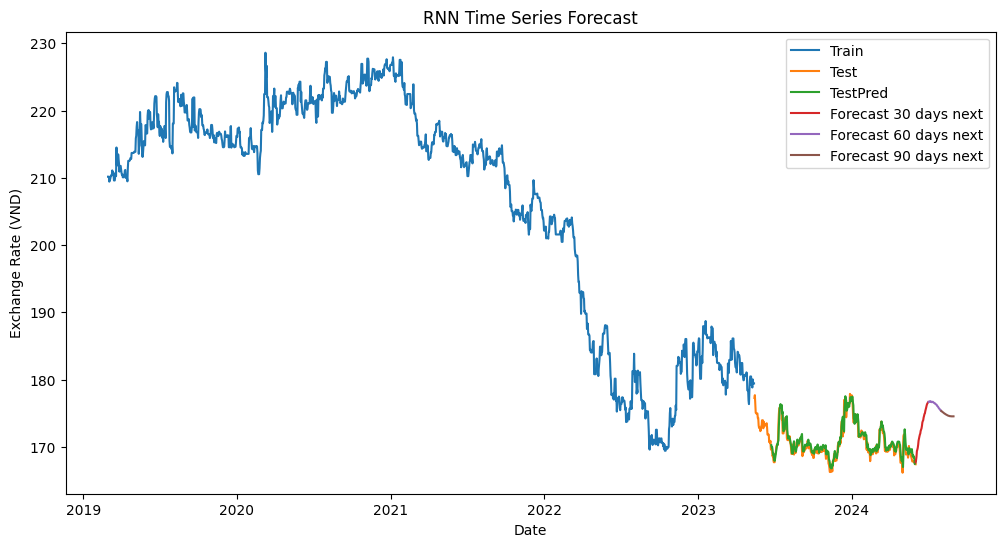

RMSE = 0.8672132494684348
MAPE(%) = 0.3689700814692313
MAE = 0.6293806493005087


In [34]:
implement_RNN(train_jpy_2_sc, test_jpy_2_sc)

- **Case 3. 9:1**

Epoch 1/100


C:\Users\TTMC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3311 - val_loss: 0.0231
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 9.7799e-04
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 9.4662e-04
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010 - val_loss: 8.6492e-04
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4429e-04 - val_loss: 7.8664e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8212e-04 - val_loss: 7.1807e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2811e-04 - val_loss: 6.5055e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7854e-04 - val_loss: 5.8726e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3322e-04 - val_loss: 5.3083e-04
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9271e-04 - val_loss: 4.8170e-04
Epoch 12/100
2

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3062e-04 - val_loss: 2.1826e-04
Epoch 66/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2852e-04 - val_loss: 2.1648e-04
Epoch 67/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2656e-04 - val_loss: 2.1492e-04
Epoch 68/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2474e-04 - val_loss: 2.1356e-04
Epoch 69/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2303e-04 - val_loss: 2.1236e-04
Epoch 70/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2143e-04 - val_loss: 2.1132e-04
Epoch 71/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1993e-04 - val_loss: 2.1041e-04
Epoch 72/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1851e-04 - val_loss: 2.0960e-04
Epoch 73/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1717e-04 - val_loss: 2.0889e-04
Epoch 74/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1589e-04 - val_loss: 2.0824e-04
Epoch 75/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1468e-04 - 

8 day output [[0.07493099]]
9 day input [0.05188981 0.08728379 0.09096733 0.09096733 0.07399103 0.06278027
 0.05076874 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259
 0.03587444 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852
 0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.02499128 0.02946095 0.0358231  0.04738139 0.04982237
 0.05279934 0.06119211 0.07069322 0.07493099]
9 day output [[0.08191074]]
10 day input [0.08728379 0.09096733 0.09096733 0.07399103 0.06278027 0.05076874
 0.04324151 0.04596413 0.04596413 0.04596413 0.04436259 0.03587444
 0.04228059 0.06374119 0.0470852  0.0470852  0.0470852  0.04788597
 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568 0.02674568
 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937 0.02017937
 0.02499128 0.02946095 0.0358231  0.04738139 0.04982237 0.05279934
 0.06119211 0.07069322 0.07493099 0.08191074]
10 day output [[0.087240

25 day output [[0.16574377]]
26 day input [0.0470852  0.04788597 0.04003844 0.03619475 0.0318706  0.02674568
 0.02674568 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614
 0.02017937 0.02017937 0.02499128 0.02946095 0.0358231  0.04738139
 0.04982237 0.05279934 0.06119211 0.07069322 0.07493099 0.08191074
 0.08724021 0.09016593 0.0972319  0.10135985 0.10483528 0.1102336
 0.11864493 0.12293153 0.12621889 0.13338991 0.13937256 0.14459449
 0.14782622 0.15483838 0.16031221 0.16574377]
26 day output [[0.17167106]]
27 day input [0.04788597 0.04003844 0.03619475 0.0318706  0.02674568 0.02674568
 0.02674568 0.02834721 0.02610506 0.02466368 0.02722614 0.02017937
 0.02017937 0.02499128 0.02946095 0.0358231  0.04738139 0.04982237
 0.05279934 0.06119211 0.07069322 0.07493099 0.08191074 0.08724021
 0.09016593 0.0972319  0.10135985 0.10483528 0.1102336  0.11864493
 0.12293153 0.12621889 0.13338991 0.13937256 0.14459449 0.14782622
 0.15483838 0.16031221 0.16574377 0.17167106]
27 day output [[0.177

44 day output [[0.23282671]]
45 day input [0.05279934 0.06119211 0.07069322 0.07493099 0.08191074 0.08724021
 0.09016593 0.0972319  0.10135985 0.10483528 0.1102336  0.11864493
 0.12293153 0.12621889 0.13338991 0.13937256 0.14459449 0.14782622
 0.15483838 0.16031221 0.16574377 0.17167106 0.17722175 0.18148842
 0.18586251 0.19072416 0.19392613 0.19781965 0.20214719 0.20490962
 0.20710406 0.2107864  0.21340349 0.2154083  0.21904197 0.22218618
 0.22484708 0.22734889 0.23053545 0.23282671]
45 day output [[0.23583612]]
46 day input [0.06119211 0.07069322 0.07493099 0.08191074 0.08724021 0.09016593
 0.0972319  0.10135985 0.10483528 0.1102336  0.11864493 0.12293153
 0.12621889 0.13338991 0.13937256 0.14459449 0.14782622 0.15483838
 0.16031221 0.16574377 0.17167106 0.17722175 0.18148842 0.18586251
 0.19072416 0.19392613 0.19781965 0.20214719 0.20490962 0.20710406
 0.2107864  0.21340349 0.2154083  0.21904197 0.22218618 0.22484708
 0.22734889 0.23053545 0.23282671 0.23583612]
46 day output [[0.23

64 day output [[0.28269982]]
65 day input [0.16574377 0.17167106 0.17722175 0.18148842 0.18586251 0.19072416
 0.19392613 0.19781965 0.20214719 0.20490962 0.20710406 0.2107864
 0.21340349 0.2154083  0.21904197 0.22218618 0.22484708 0.22734889
 0.23053545 0.23282671 0.23583612 0.23878348 0.24106637 0.24359781
 0.24657306 0.24929935 0.25115097 0.25376123 0.25642511 0.25872019
 0.26075327 0.26325238 0.26585016 0.26794568 0.2703588  0.27273828
 0.27511272 0.27758282 0.28030184 0.28269982]
65 day output [[0.28528574]]
66 day input [0.17167106 0.17722175 0.18148842 0.18586251 0.19072416 0.19392613
 0.19781965 0.20214719 0.20490962 0.20710406 0.2107864  0.21340349
 0.2154083  0.21904197 0.22218618 0.22484708 0.22734889 0.23053545
 0.23282671 0.23583612 0.23878348 0.24106637 0.24359781 0.24657306
 0.24929935 0.25115097 0.25376123 0.25642511 0.25872019 0.26075327
 0.26325238 0.26585016 0.26794568 0.2703588  0.27273828 0.27511272
 0.27758282 0.28030184 0.28269982 0.28528574]
66 day output [[0.288

84 day output [[0.3358363]]
85 day input [0.23583612 0.23878348 0.24106637 0.24359781 0.24657306 0.24929935
 0.25115097 0.25376123 0.25642511 0.25872019 0.26075327 0.26325238
 0.26585016 0.26794568 0.2703588  0.27273828 0.27511272 0.27758282
 0.28030184 0.28269982 0.28528574 0.28804621 0.29055157 0.29302388
 0.29576135 0.29850629 0.30093989 0.30364418 0.30633146 0.30888847
 0.31149697 0.31419206 0.31682822 0.31946161 0.32223836 0.32488459
 0.32756466 0.3303332  0.33315161 0.33583629]
85 day output [[0.3386015]]
86 day input [0.23878348 0.24106637 0.24359781 0.24657306 0.24929935 0.25115097
 0.25376123 0.25642511 0.25872019 0.26075327 0.26325238 0.26585016
 0.26794568 0.2703588  0.27273828 0.27511272 0.27758282 0.28030184
 0.28269982 0.28528574 0.28804621 0.29055157 0.29302388 0.29576135
 0.29850629 0.30093989 0.30364418 0.30633146 0.30888847 0.31149697
 0.31419206 0.31682822 0.31946161 0.32223836 0.32488459 0.32756466
 0.3303332  0.33315161 0.33583629 0.3386015 ]
86 day output [[0.3414

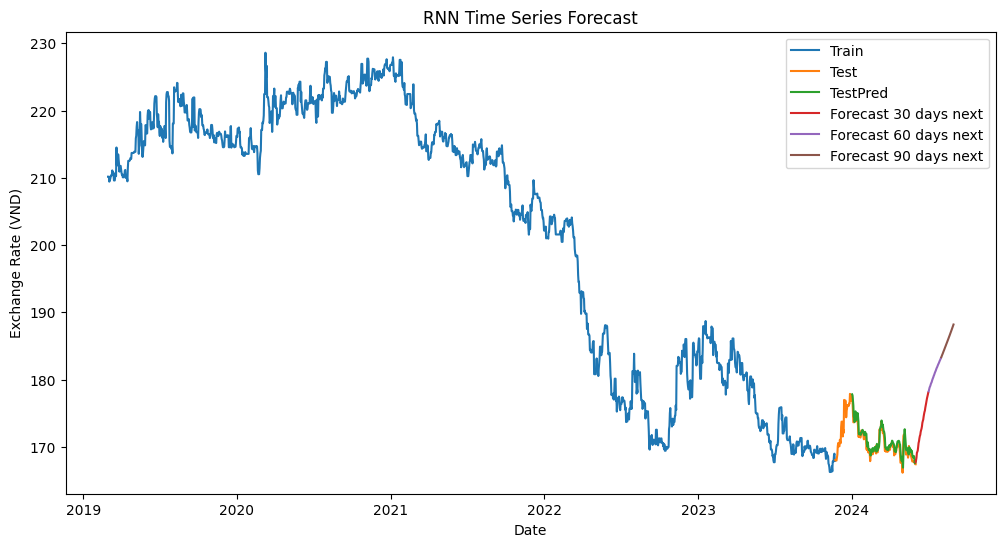

RMSE = 0.8701128702210326
MAPE(%) = 0.3962204312974618
MAE = 0.6747514784963514


In [35]:

implement_RNN(train_jpy_3_sc, test_jpy_3_sc)